In [2]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [9]:
user,item,title = 'userId','movieId','title'

In [10]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [11]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.596998,0.934898,00:00
1,0.851679,0.681861,00:00
2,0.655506,0.671020,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [15]:
path=Config.data_path()/'ml-100k'

In [16]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
len(ratings)

100000

In [19]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [20]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [21]:
data.show_batch()

userId,title,target
506,Pretty Woman (1990),4.0
328,Braveheart (1995),5.0
221,Home Alone (1990),3.0
402,Sleepers (1996),3.0
128,"Bridges of Madison County, The (1995)",1.0


In [22]:
y_range = [0,5.5]

In [23]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


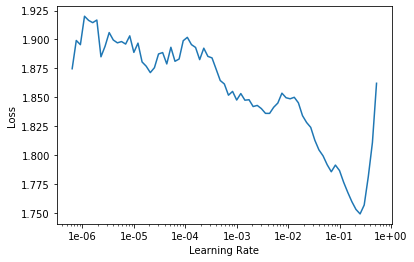

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.948737,0.943256,00:05
1,0.858683,0.884733,00:05
2,0.761240,0.836612,00:05
3,0.653600,0.810441,00:05
4,0.568234,0.810139,00:05


In [26]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [28]:
learn.load('dotprod');

In [29]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [30]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [31]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [32]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [33]:
item0 = lambda o:o[0]

In [34]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3687),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3153),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2787), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2692), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2677), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2668), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2466), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2439), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2282), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2260), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2200), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2151), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2146), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2139), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2109), 'Bio-Dome (1996)', 1.903

In [35]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5893), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5752), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5695), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5283), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5268), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5175), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4952), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4923), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4922), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4773), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4653), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4648), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4596), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4515), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4504), 'Casablanca (1942)', 4.45679012345679)]

### Movie weights

In [36]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [37]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [38]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [39]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1398), 'Wrong Trousers, The (1993)'),
 (tensor(1.0631), 'Chinatown (1974)'),
 (tensor(1.0478), 'Lawrence of Arabia (1962)'),
 (tensor(1.0430), 'Casablanca (1942)'),
 (tensor(1.0365), 'When We Were Kings (1996)'),
 (tensor(1.0246), 'Close Shave, A (1995)'),
 (tensor(0.9698), 'Persuasion (1995)'),
 (tensor(0.9661), 'Ran (1985)'),
 (tensor(0.9635), 'Apocalypse Now (1979)'),
 (tensor(0.9565),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)')]

In [40]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2843), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.2616), "McHale's Navy (1997)"),
 (tensor(-1.2243), 'Jungle2Jungle (1997)'),
 (tensor(-1.2119), 'Home Alone 3 (1997)'),
 (tensor(-1.1770), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1647), 'Leave It to Beaver (1997)'),
 (tensor(-1.1040), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1018), 'Grease 2 (1982)'),
 (tensor(-1.0888), 'Congo (1995)'),
 (tensor(-1.0735), 'Bio-Dome (1996)')]

In [41]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [42]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1287), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0984), 'Braveheart (1995)'),
 (tensor(1.0563), 'Titanic (1997)'),
 (tensor(1.0197), "It's a Wonderful Life (1946)"),
 (tensor(0.8831), 'Hunt for Red October, The (1990)'),
 (tensor(0.8792), 'Independence Day (ID4) (1996)'),
 (tensor(0.8691), 'Forrest Gump (1994)'),
 (tensor(0.8458), 'American President, The (1995)'),
 (tensor(0.8235), 'Lion King, The (1994)'),
 (tensor(0.8175), 'Star Wars (1977)')]

In [43]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8744), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.7996), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.7856), 'Stupids, The (1996)'),
 (tensor(-0.7751), 'Keys to Tulsa (1997)'),
 (tensor(-0.7682), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7539), 'Trainspotting (1996)'),
 (tensor(-0.7428), 'Jude (1996)'),
 (tensor(-0.7360), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7318), 'Big Night (1996)'),
 (tensor(-0.7257), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)')]

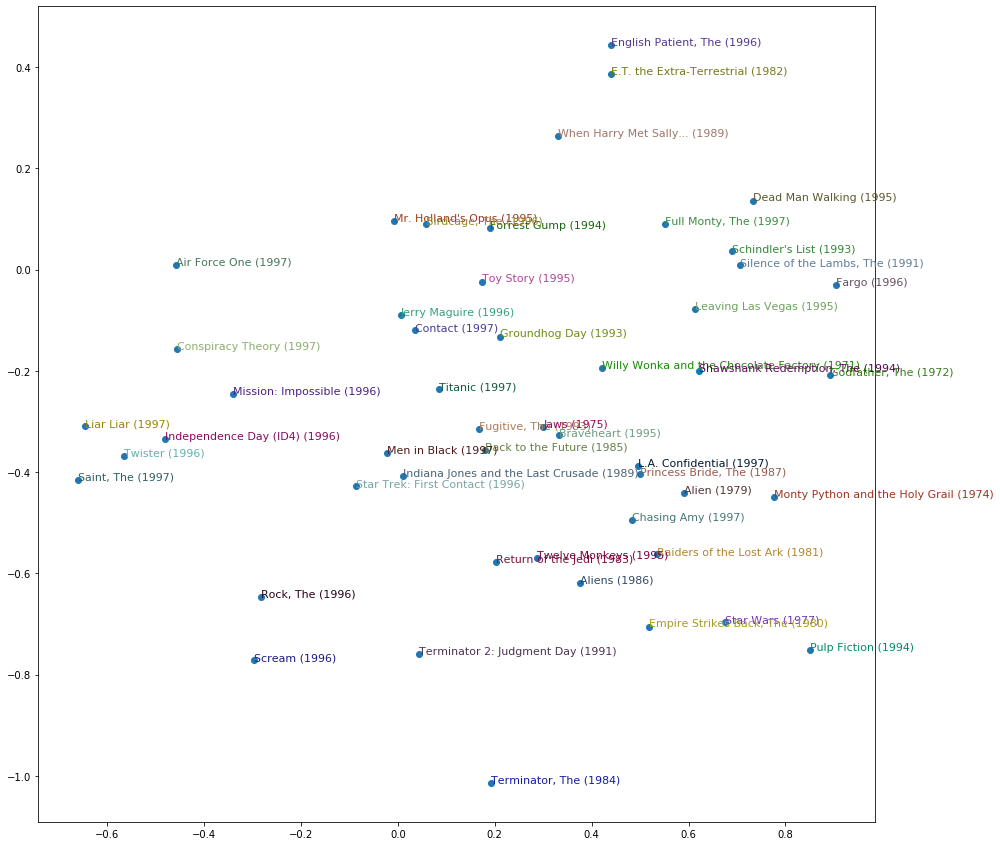

In [44]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()